## Librerías usadas

In [2]:
import requests
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
import folium

## Conexión con bigquery

In [3]:
bq_client = bigquery.Client()

In [ ]:
query = """
SELECT
  year,
  mo,
  da,
  temp
FROM
  `bigquery-public-data.noaa_gsod.gsod2022`
WHERE
  stn = '854690' AND year = '2022' AND mo = '01'
"""

df_bq = bq_client.query(query).to_dataframe()
df_bq = bq_client.query(query).to_dataframe()

df_bq["fecha"] = pd.to_datetime(
    df_bq["year"].astype(str)
    + df_bq["mo"].astype(str).str.zfill(2)
    + df_bq["da"].astype(str).str.zfill(2),
    format="%Y%m%d"
)

## Conversión de los datos de temperatura


In [ ]:
# Convierto los grados a celcius
df_bq["temp_C"] = (df_bq["temp"] - 32) * 5 / 9

In [ ]:
# Mostramos la tabla
print("\n=== Datos de BigQuery (NOAA GSOD) ===")
print(df_bq.head(10))


=== Datos de BigQuery (NOAA GSOD) ===
   year  mo  da  temp      fecha     temp_C
0  2022  01  24  74.0 2022-01-24  23.333333
1  2022  01  27  72.9 2022-01-27  22.722222
2  2022  01  13  71.1 2022-01-13  21.722222
3  2022  01  10  72.0 2022-01-10  22.222222
4  2022  01  06  73.8 2022-01-06  23.222222
5  2022  01  12  73.1 2022-01-12  22.833333
6  2022  01  01  72.4 2022-01-01  22.444444
7  2022  01  31  72.8 2022-01-31  22.666667
8  2022  01  08  73.0 2022-01-08  22.777778
9  2022  01  07  72.5 2022-01-07  22.500000


## Aquí me conecto con la API nasa power
Defino la clase para conectarme a la API pública de NASA POWER, donde extraigo los datos de la tempertura del aire a 2 metros de altura ("T2M") y precipitación corregida ("PRECTOTCORR"). La conexión la hago mediante la URL.

In [8]:
class NasaPowerClient:
    def __init__(self, community="RE"):
        self.base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
        self.community = community

    def fetch_dataset(self, latitude, longitude, start, end, parameters):
        url = (
            f"{self.base_url}?start={start}&end={end}"
            f"&latitude={latitude}&longitude={longitude}"
            f"&parameters={parameters}"
            f"&community={self.community}&format=JSON"
        )
        response = requests.get(url)
        return response.json()

# Coordenadas y fechas
lat, lon = -33.45, -70.66
start, end = "20220101", "20220131"
params = "T2M,PRECTOTCORR"


In [9]:
nasa_client = NasaPowerClient()
data = nasa_client.fetch_dataset(lat, lon, start, end, params)

Y aqui construyo un dataframe con los datos extraídos de la API, para luego mostrar los primeros 10 días.


In [10]:
df_nasa = pd.DataFrame({
    "T2M": pd.Series(data["properties"]["parameter"]["T2M"]),
    "PRECTOTCORR": pd.Series(data["properties"]["parameter"]["PRECTOTCORR"])
})
df_nasa.index = pd.to_datetime(df_nasa.index, format="%Y%m%d")


print("\n=== Datos de la API NASA ===")
print(df_nasa.head(10))


=== Datos de la API NASA ===
              T2M  PRECTOTCORR
2022-01-01  20.26         0.00
2022-01-02  20.64         0.00
2022-01-03  21.50         0.00
2022-01-04  21.08         0.00
2022-01-05  21.84         0.00
2022-01-06  21.53         0.44
2022-01-07  22.69         0.37
2022-01-08  22.01         0.00
2022-01-09  20.22         1.60
2022-01-10  21.38         3.26


## Unión datos
Aqui combino los datos de ambas fuentes (BigQuery con NASA  POWER) y los muestro abajo para ver si funcionó


In [11]:
# parte 2

df_bq_grouped = df_bq.groupby("fecha")["temp_C"].mean().reset_index()

df_nasa_grouped = df_nasa.copy()
df_nasa_grouped["fecha"] = df_nasa_grouped.index

merged_df = pd.merge(df_bq_grouped, df_nasa_grouped, on="fecha", how="inner")

merged_df.rename(columns={
    "temp_C": "BigQuery_TEMP_C",
    "T2M": "NASA_T2M_C"
}, inplace=True)

print("\n=== Datos combinados BigQuery + NASA ===")
print(merged_df.head(10))



=== Datos combinados BigQuery + NASA ===
       fecha  BigQuery_TEMP_C  NASA_T2M_C  PRECTOTCORR
0 2022-01-01        22.444444       20.26         0.00
1 2022-01-02        21.722222       20.64         0.00
2 2022-01-03        21.611111       21.50         0.00
3 2022-01-04        21.722222       21.08         0.00
4 2022-01-05        21.166667       21.84         0.00
5 2022-01-06        23.222222       21.53         0.44
6 2022-01-07        22.500000       22.69         0.37
7 2022-01-08        22.777778       22.01         0.00
8 2022-01-09        23.833333       20.22         1.60
9 2022-01-10        22.222222       21.38         3.26


## Comparación de temperaturas de BigQuey vs NASA
Lo que se muestra en el gráfico es la comparación de temperaturas promedio diarias durante enero de 2022 por las 2 fuentes

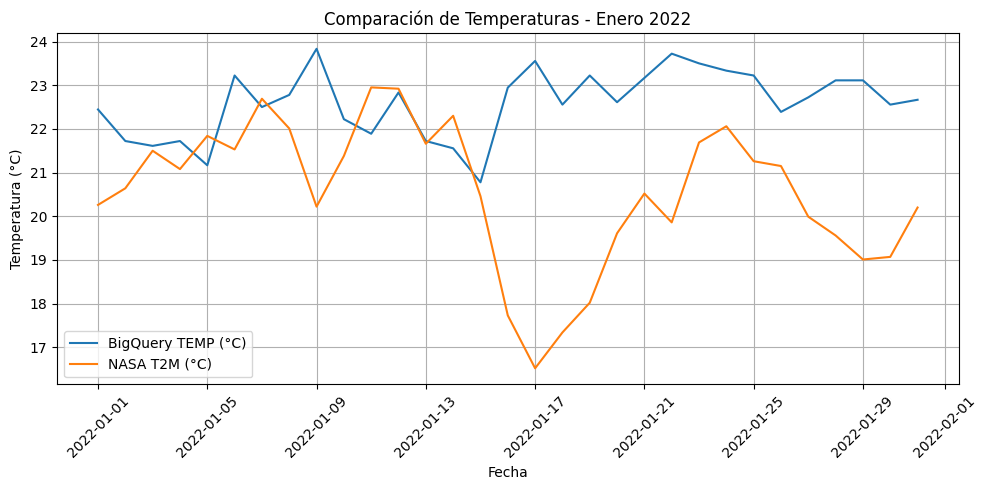

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(merged_df["fecha"], merged_df["BigQuery_TEMP_C"], label="BigQuery TEMP (°C)")
plt.plot(merged_df["fecha"], merged_df["NASA_T2M_C"], label="NASA T2M (°C)")
plt.title("Comparación de Temperaturas - Enero 2022")
plt.xlabel("Fecha")
plt.ylabel("Temperatura (°C)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Precipitación diaria (NASA)

Aqui se muestra la cantidad de precipitación total diaria registrada por la NAASA en esa fecha. Se destaca que la mayoría de los días del mes no presentan precipitaciones significativas. Hubo algunos eventos de mayor intensidad que se muestra con peaks en el histograma (días 9-1-2022 y 25-1-2022).

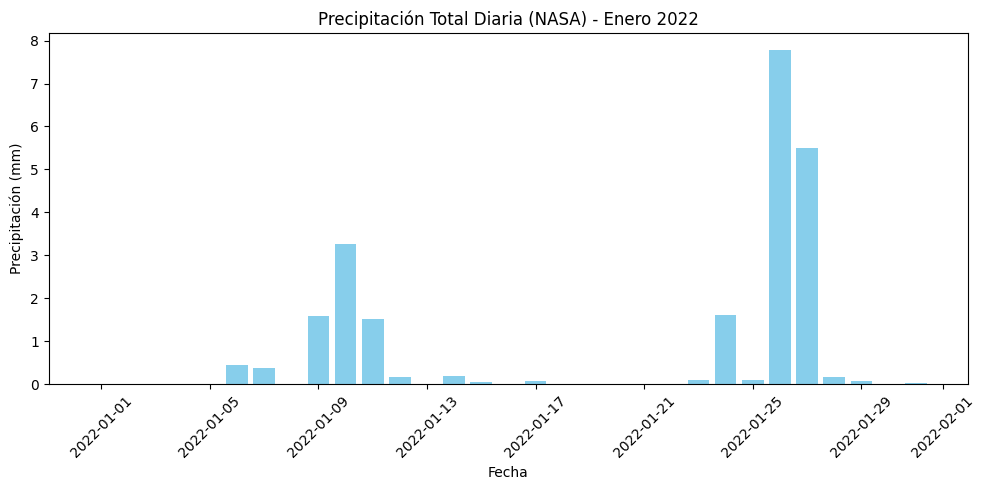

In [13]:
# 2. Precipitación diaria (NASA)
plt.figure(figsize=(10, 5))
plt.bar(merged_df["fecha"], merged_df["PRECTOTCORR"], color='skyblue')
plt.title("Precipitación Total Diaria (NASA) - Enero 2022")
plt.xlabel("Fecha")
plt.ylabel("Precipitación (mm)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## gráfico combinado: temperatura con las precipitaciones del gráfico anterior

aqui combiné el gráfico anterior con el gráfico de los datos de la temperatura de la NASA, podemos ver en el eje y izquierdo la variable de Temperatura, y en el lado derecho en el eje Y vemos la variable de precipitación

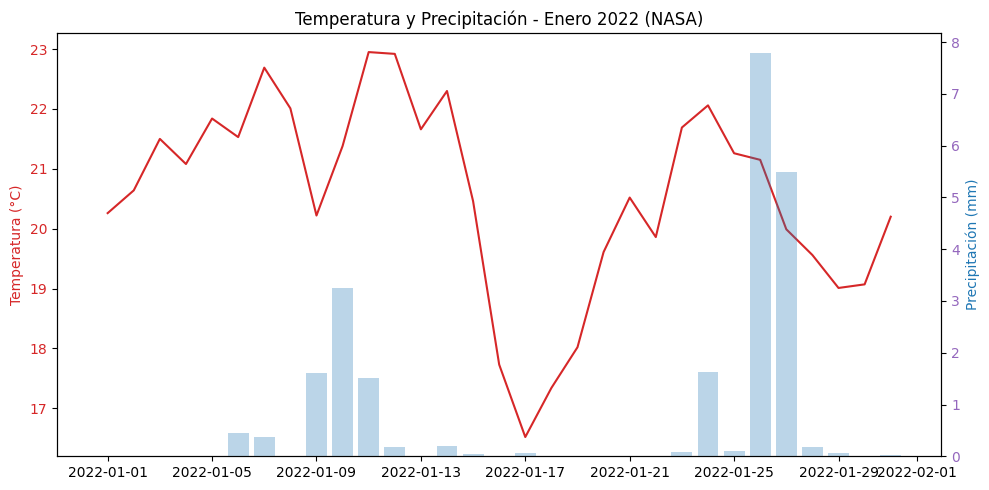

In [14]:
# 3. Gráfico combinado: Temperatura (línea) y Precipitación (barras)
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(merged_df["fecha"], merged_df["NASA_T2M_C"], color='tab:red', label="NASA T2M")
ax1.set_ylabel("Temperatura (°C)", color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax2 = ax1.twinx()
ax2.bar(merged_df["fecha"], merged_df["PRECTOTCORR"], alpha=0.3, color='tab:blue', label="Precipitación")
ax2.set_ylabel("Precipitación (mm)", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:purple')
plt.title("Temperatura y Precipitación - Enero 2022 (NASA)")
fig.tight_layout()
plt.xticks(rotation=45)
plt.show()

## Matriz de correlación entre variables

aqui se presentan los coeficientes de correlación de Pearson entre las 3 variables. Si vemos resultado como 1 indica correlación positiva perfecta, si vemos 0 indica que no hay correlación y -1 indica que hay correlación negativa perfecta. Aqui observamos valores como hay una correlación entre cada variable consigo misma obviamente, los valores de -0.35 entre las temperaturas de BigQuery y la NASA que podría ser por diferencias del tipo de medición quizás, y que la correlación entre temperatura y precipitación es muy baja, lo que puede decir que no necesariamente llueve cuando hace más o menos calor.

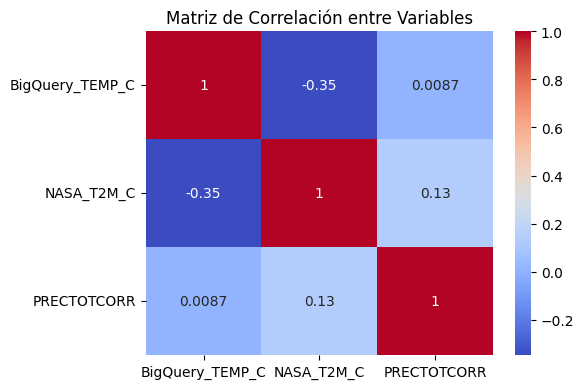

In [15]:
# 4. Heatmap de correlación
plt.figure(figsize=(6, 4))
sns.heatmap(merged_df[["BigQuery_TEMP_C", "NASA_T2M_C", "PRECTOTCORR"]].corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación entre Variables")
plt.tight_layout()
plt.show()

## Diferencia diaria de temperaturas: Bigquery vs NASA

En este último gráfico presento las diferencias de temperaturas de los datos y mido la discrepancia entre las fuentes, lo que vemos que hay mucha variabilidad (los valores cercanos a 0 es que ambas coinciden).

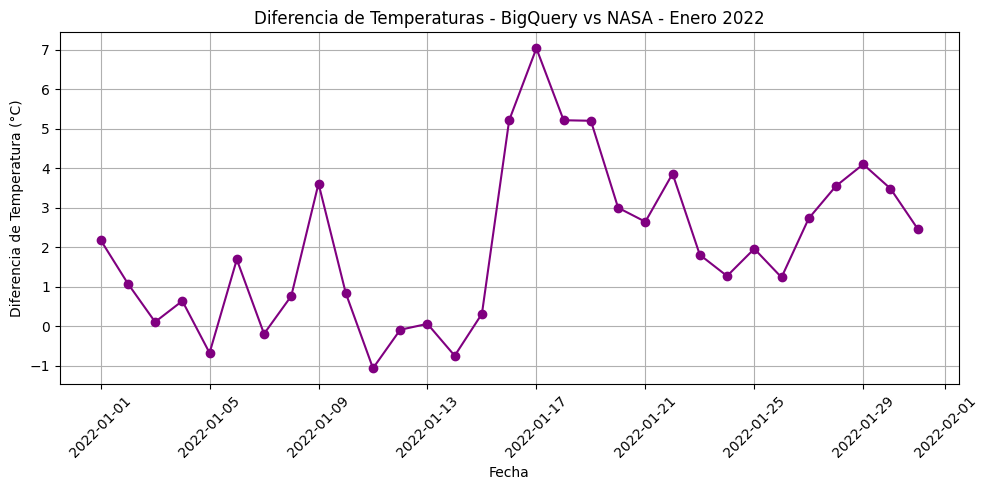

In [19]:
#5
merged_df["Diferencia_TEMP"] = merged_df["BigQuery_TEMP_C"] - merged_df["NASA_T2M_C"]
plt.figure(figsize=(10, 5))
plt.plot(merged_df["fecha"], merged_df["Diferencia_TEMP"], marker='o', linestyle='-', color='purple')
plt.title("Diferencia de Temperaturas - BigQuery vs NASA - Enero 2022")
plt.xlabel("Fecha")
plt.ylabel("Diferencia de Temperatura (°C)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()